### 1.  정확도(Accuracy) : 실제데이터와 예측데이터가 얼마나 같은지를 판단하는 지표 

 - 정확도 = 예측 데이터가 동일한 데이터 건수 / 전체 예측 데이터 건수
 - 직관적으로 모델 예측 성능을 나타내는 평가 지표이지만 이진 분류의 경우 데이터의 구성에 따라 모델 성능을 왜곡할 수 있음
 
   가령, 타이타닉 예제에서도 여성의 생존률이 높았기 때문에, 특별한 알고리즘 없이 여성을 생존, 남성을 사망으로 분류해도 정확도는 높을 수 있음
  ( 단순히 하나의 조건만 가지고 결정하는 알고리즘도 높은 정확도를 나타내는 상황이 발생)
   

사이킷런의 **BaseEstimator** 클래스를 활용하여, 단순히 성별에 따라 생존자를 예측하는 단순한 분류기를 생성

 * 사이킷런의 BaseEsimators를 활용하면 Customized된 Estimator를 생성할 수 있음

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import warnings 
warnings.filterwarnings('ignore')

In [2]:
### fit() 메서드는 아무 것도 수행하지 않고, predict()는 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 단순한 분류기 생성
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict 메서드는 단순히 Sex 피처가 1이면 0, 아니면 1로 예측
    def predict(self, X):
        pred = np.zeros( (X.shape[0],1) )
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1 
        return pred

In [3]:
## 생성된 MyDummyClassifier를 이용해 타이타닉 생존자 예측 수행

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

## Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

## 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

## Label Encoding 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

## 앞에서 실행한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
# 타이타닉 데이터 로딩 및 학습 데이터 / 테스트 데이터 분할
titanic_df = pd.read_csv('Titanic/input/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(['Survived'], axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [5]:
# 위에서 생성한 Dummy Classifier를 활용해서 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도: {0: .4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도:  0.7877


위와 같은 단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도는 78.77%로 매우 높은 수치로 나올 수 있기 때문에 정확도를 평가지표로 사용할 때는 매우 신중해야 함.

특히, Imbalanced한 레이블 값 분포에서 모델 성능을 판단할 경우에는 적합한 평가 지표가 아님
 - 가령, 100개의 데이터 중 90개의 레이블이 0, 10개의 레이블이 1인 경우에 무조건 0을 반환하는 모델을 만들면 정확도가 90%가 됨

#### MNIST 데이터 세트를 변환하여 불균형한 데이터 세트를 만든 뒤 정확도 지표 적용시 어떤 문제가 발생할 수 있는지 살펴보기

* MNIST 데이터세트: 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit을 예측하는데 사용
  - 0부터 9까지의 멀티레이블이지만 True, 나머지는 False인 불균형한 데이터 세트로 변환
  - 이후에 모든 데이터를 False(0)으로 예측하는 분류기를 만들어 정확도를 측정
  - 결과적으로 아무것도 하지 않고, 특정 결과로만 결과를 반환해도 정확도가 높게 측정되어 모델 성능이 높게 나타나는 현상이 발생

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
        
# 사이킷런의 내장 데이터 셋인 load_digits()를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 astype(int)로 1로 변환, 7이 아니면 False이고 0으로 변환
y=(digits.target == 7).astype(int)

# 훈련셋, 테스트셋으로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [7]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 데이터 크기: ', y_test.shape)
print('테스트 데이터 세트 레이블 0과 1의 분포도: ')
print(pd.Series(y_test).value_counts())

# FakeClassifier를 통해 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fake_prediction = fakeclf.predict(X_test)
print('모든 예측을 0으로 했을 때의 정확도: ', accuracy_score(y_test, fake_prediction))

레이블 테스트 데이터 크기:  (450,)
테스트 데이터 세트 레이블 0과 1의 분포도: 
0    405
1     45
dtype: int64
모든 예측을 0으로 했을 때의 정확도:  0.9


위와 같이 단순히 한 가지 값만으로 결과를 반환해도 정확도의 90%를 나타냄

이처럼 정확도 평가지표는 불균형한 레이블 데이터 셋에서는 성능지표로 사용되서는 안됨

--> 이를 극복하기 위해 정확도는 여러 지표와 함께 적용되어야 함

### 2. 오차행렬(Confusion Matrix) 
 : 분류 문제에서 예측 오류가 얼마인지, 어떤 유형의 오류가 발생하고 있는지를 함께 나타내는 지표

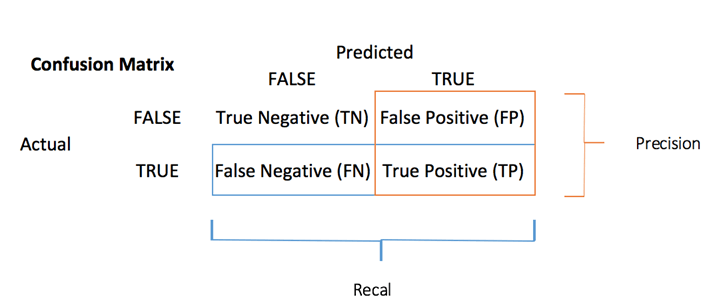

In [8]:
Image('image/confusionMatrx.png', width = 700)

* $TN(True Negative)$ : 실제 값이 Negative인데 예측 값도 Negative
* $FP(False Positive)$ : 실제 값이 Negative인데 예측 값을 Positive
* $FN(False Negative)$ : 실제 값이 Positive인데 예측 값을 Negative
* $TP(True Positive)$ : 실제 값이 Positive인데 예측 값도 Positive

사이킷런에서는 오차행렬을 구하기 위해 **confusion_matrix( )**를 제공

In [9]:
# MyFakeClassifier의 예측 결과인 fakepred와 실제결과인 y_test를 confusion_matrix의 인자로 입력해서 출력
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, fake_prediction)
cm

array([[405,   0],
       [ 45,   0]])

오차행렬은 ndarray형태로 TP, FP, FN, TN은 위의 상단 표와 동일하게 배치

위의 결과를 보면 총 450개의 값 중
 
  - TN : 405개, TP : 0개, FN : 45개, FP : 0개 
  

In [10]:
print('True Negative : ' , cm[0][0], ' --> (7이 아닌데 7이 아니라고 예측)')
print('False Positive : ', cm[0][1], '--> (7이 아닌데 7이라고 예측)')
print('False Negative : ', cm[1][0], '--> (7인데 7이 아니라고 예측)')
print('True Positigve: ', cm[1][1], '--> (7인데 7이라고 예측)')

True Negative :  405  --> (7이 아닌데 7이 아니라고 예측)
False Positive :  0 --> (7이 아닌데 7이라고 예측)
False Negative :  45 --> (7인데 7이 아니라고 예측)
True Positigve:  0 --> (7인데 7이라고 예측)


### 3. 오차행렬을 통해 알 수 있는 지표들

* $ Accuracy (정확도) = \frac{TN+TP}{TN+FP+FN+TP}\ $ --> 예측결과와 실제값이 동일한 건수 / 전체 데이터 수

* $ Precision (정밀도) = \frac{TP}{FP+TP}\ $ --> 예측대상(Positive)을 정확히 예측한 수 / Positive로 예측한 데이터 수

* $ Recall(재현율) , Sensitivity(민감도), True Positive Rate(TPR) = \frac{TP}{FN+TP}\ $ --> Positive를 정확히 예측한 수 / 전체 Positive 데이터 수

* $ Specificity(특이성), True Negative Rate(TNR) = \frac{TN}{TN+FP}\ $

업무 특성에 따라서 특정지표가 유용하게 사용

ex) Recall(재현율) : 암 판정, 사기 판정  / Precision(정밀도) : 스팸메일 분류

* 사이킷런에서는 정밀도 계산을 위해 **precision_score( )** , 재현율 계산을 위해 **recall_score( )** 를 제공

In [11]:
# 사이킷런의 정확도, 정밀도, 재현율, 오차행렬을 계산하는 API 호출
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 호출한 지표들을 한꺼번에 계산하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))

In [12]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측 후 평가 수행
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('Titanic/input/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659
정밀도 : 0.8246
재현율 : 0.7705


### 4. 정밀도/재현율 트레이드오프

* 정밀도와 재현율은 상호보완적인 지표로 한쪽을 높이려고 하다보면 다른 한쪽이 떨어지기 쉬움

* 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지 판단하기 위해 개별 레이블별로 확률을 구하고, 그 확률이 큰 레이블 값으로 예측
  - 일반적으로는 임계값을 50%로 정하고 이보다 크면 Positive, 작으면 Negative로 결정
  - **predict_proba( )** 를 통하여 개별 레이블별 예측확률을 반환받을 수 있음

In [13]:
# 타이타닉  생존자 데이터에서 predict() 결과 값과 predict_proba() 결과 값을 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba의 shape: {0}'.format(pred_proba.shape))
print('pred_proba의 array에서 앞 3개만 샘플로 추출 :\n', pred_proba[:3])

#예측확률 array와 예측 결과값 array를 병합하여 예측확률과 결괏값을 한 번에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba의 shape: (179, 2)
pred_proba의 array에서 앞 3개만 샘플로 추출 :
 [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중 더 큰 확률을 클래스 값으로 예측
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


반환 결과인 ndarray는 0과 1에 대한 확률을 나타내므로 첫번째 컬럼과 두번째 컬럼의 합은 1이 됨

그리고 두 확률 중 큰 값의 레이블 값으로 predict( ) 메서드가 최종 예측

#### 정밀도/재현율 트레이드오프를 살펴보기 위해 로직을 구현해보기

* 사이킷런의 **Binarizer** 클래스 : fit_transform()을 이용하여 정해진 threshold 보다 같거나 작으면 0, 크면 1로 변환하여 반환

In [14]:
from sklearn.preprocessing import Binarizer

# 예시
X = [[-1, -1, 2],
        [2, 0, 0], 
        [0, 1.1, 1.2]]

# X의 개별원소들이 threshold보다 크면 1, 작거나 같으면 0을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


앞선 Logistic Regression 객체의 predict_proba()의 결과 값에 Binarizer클래스를 적용하여 최종 예측 값을 구하고, 최종 예측 값에 대해 평가해보기

In [15]:
# Binarizer의 threshold 값을 0.5로 설정
custom_threshold = 0.5

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659
정밀도 : 0.8246
재현율 : 0.7705


In [16]:
# Binarizer의 threshold 값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[97 21]
 [11 50]]
정확도 : 0.8212
정밀도 : 0.7042
재현율 : 0.8197


--> threshold를 낮추니 정밀도는 떨어지고, 재현율이 올라감
     (즉, 0.4부터 Positive로 예측을 하니, 전체 Positive 수 대비 Positive로 예측된 값의 수가 많아짐)

임계값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가지표를 조사

In [17]:
# 임계값
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[97 21]
 [11 50]]
정확도 : 0.8212
정밀도 : 0.7042
재현율 : 0.8197

임계값:  0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547
정밀도 : 0.7869
재현율 : 0.7869

임계값:  0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659
정밀도 : 0.8246
재현율 : 0.7705

임계값:  0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715
정밀도 : 0.8654
재현율 : 0.7377

임계값:  0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771
정밀도 : 0.8980
재현율 : 0.7213


* **precision_recall_curve(실제 클래스 값, 예측 확률 값)** : 임계값 변화에 따른 평가 지표 값을 반환하는 API
  - 반환 값 : *정밀도* - 임계값별 정밀도 값을 배열으로 반환, *재현율* - 임계값별 재현율 값을 배열으로 반환

In [18]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 떄의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[ : , 1]

# 실제값 데이터 세트와 레이블 값이 1일 때 예측확률을 precision_recall_curve의 인자로 반환
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape: ', thresholds.shape)

# 반환된 임계값 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape:  (147,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도 :  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


정밀도와 재현율 값을 살펴보면 임계값이 증가할 수록 정밀도 값은 동시에 높아지나 재현율 값이 낮아짐을 알 수 있음

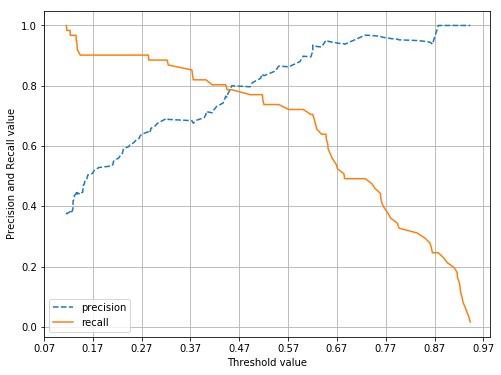

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 4. F1 스코어

정밀도와 재현율을 결합한 지표로 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 상대적으로 높은 값을 가짐

$$
F1 = \frac {2}{\frac{1}{recall}+\frac{1}{precision}}\ = 2 * \frac{precision * recall}{precision+recall}\
$$

예시 ) 모델 A : 정밀도 0.9, 재현율이 0.1  , 모델 B : 정밀도 0.5, 재현율 0.5 일 때

--> 모델 A의 F1 = 0.18 , 모델 B의 F1 = 0.5

**f1_score(실제값, 예측값)** : 사이킷런에서 F1스코어를 측정

In [20]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {:.4f}'.format(f1))

F1 스코어 : 0.7966


#### 타이타닉 생존자 예측에서 임계값을 변화시키며 F1 스코어, 정밀도, 재현율 구하기

In [21]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # F1 score print 추가
    print('\n정확도: {:.4f}\n정밀도: {:.4f}\n재현율: {:.4f}\nF1: {:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[97 21]
 [11 50]]

정확도: 0.8212
정밀도: 0.7042
재현율: 0.8197
F1: 0.7576

임계값:  0.45
오차행렬
[[105  13]
 [ 13  48]]

정확도: 0.8547
정밀도: 0.7869
재현율: 0.7869
F1: 0.7869

임계값:  0.5
오차행렬
[[108  10]
 [ 14  47]]

정확도: 0.8659
정밀도: 0.8246
재현율: 0.7705
F1: 0.7966

임계값:  0.55
오차행렬
[[111   7]
 [ 16  45]]

정확도: 0.8715
정밀도: 0.8654
재현율: 0.7377
F1: 0.7965

임계값:  0.6
오차행렬
[[113   5]
 [ 17  44]]

정확도: 0.8771
정밀도: 0.8980
재현율: 0.7213
F1: 0.8000


### 5. ROC곡선과 AUC

 $ROC 곡선$ :  FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선

* $ Recall(재현율) , Sensitivity(민감도),TPR = \frac{TP}{FN+TP}\ $ --> 실제값 Positive가 정확이 예측되야 하는 수준(질병 보유자를 질병을 보유한 것으로 판정)

 * $ Specificity(특이성), True Negative Rate(TNR) = \frac{TN}{TN+FP}\ $ --> 실제값 Negative가 정확히 예측되야 하는 수준(건강한 사람을 건강하다고 판정)

 * $FPR = 1 - Specificity  = \frac{FP}{TN+FP}\ $ --> 실제값 Negative 중 Positive로 잘못 예측된 비율(건강한 사람을 질병이 있다고 판정)

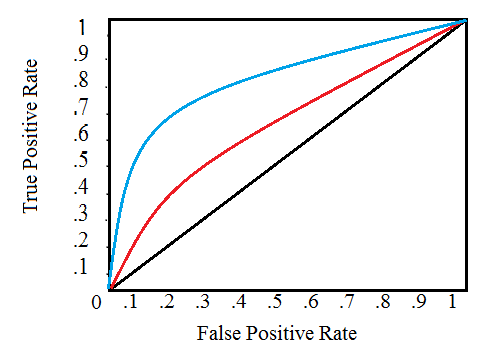

In [22]:
Image('image/ROC-curve.png', width=500)

* 위의 그림은 ROC 곡선의 예시이며 가운데 직선은 ROC 곡선의 최저 값

 - 가운데 직선은 동전을 무작위로 던져 앞/뒤를 맞추는 랜덤 수준의 이진 분류 ROC 직선
 
 
* 곡선이 가운데 직선에 가까울 수록 성능이 떨어지는 것이며 멀어질수록 성능이 뛰어난 것

* ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구함
 
  - 분류결정 임계값을 변경함으로써 FPR을 변화시킴('임계값=1'이면 Negative 값을 Positive로 예측하지 않고 FPR이 0이됨, 반대로 임계값을 낮출수록 FPR이 올라감)

**roc_curve(실제값, 예측 확률 값)** : FPR, TPR, 임계값을 반환

#### 타이타닉 생존자 예측모델의 FPR, TPR, 임계값 구하기

In [23]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되 임계값을 5step으로 추출
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 5 step으로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개:  [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임계값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


roc_curve( ) 의 결과값을 보면 임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커짐

FPR이 조금씩 커질 때 FPR은 가파르게 커짐

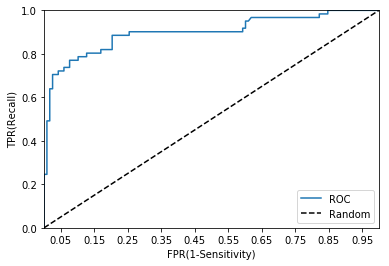

In [24]:
# ROC 곡선의 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을반환 받음
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    # ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하여 분류의 성능지표로는 ROC면적에 기반한 AUC 값으로 결정

 - **AUC(Area Under Curve)** : 곡선 밑의 면적 값으로 1에 가까울 수록 좋은 수치, 대각선 직선일 때 0.5

* **roc_auc_score( )** : AUC 면적을 구하는 사이킷런 API

In [25]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

ROC AUC 값 : 0.8429
